# Imports

In [69]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from config.settings import saved_models_path

from src.utils.column_import import columns
s_x, s_y, v_x, v_y, a_x, a_y = columns
 

## Load models 

In [70]:
# Load the models
def load_model(model_name):
    model_file_path = os.path.join(saved_models_path, f'acceleration_model_4/{model_name}.pkl')
    
    if os.path.exists(model_file_path):
        with open(model_file_path, 'rb') as file:
            loaded_model = pickle.load(file)
        
        print(f'Model "{model_name}" loaded from: {model_file_path}')
        return loaded_model
    else:
        print(f'Model file not found for "{model_name}"')
        print(model_file_path)
        return None

loaded_first_model = load_model('first_model')
loaded_second_model = load_model('second_model')


Model "first_model" loaded from: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/first_model.pkl
Model "second_model" loaded from: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/second_model.pkl


## Load the coefficients

In [71]:
# Get the coefficients
c_1_overline = np.float128(loaded_first_model.coef_[0])
c_2_overline = np.float128(loaded_first_model.coef_[1])
c_3_overline = np.float128(loaded_second_model.coef_[0])
c_4_overline = np.float128(loaded_second_model.coef_[1])

print(f'C̅₁: {c_1_overline}')
print(f'C̅₂: {c_2_overline}')
print(f'C̅₃: {c_3_overline}')
print(f'C̅₄: {c_4_overline}')

# Rearange the coefficients
c_2 = np.reciprocal( c_2_overline)
c_1 = np.multiply(c_1_overline, c_2)
c_4 = np.reciprocal( c_4_overline)
c_3 = np.multiply( c_3_overline, c_4) 

print(f'c₁: {c_1}')
print(f'c₂: {c_2}')
print(f'c₃: {c_3}')
print(f'c₄: {c_4}')


C̅₁: -0.9952445671614876
C̅₂: -7.628629025987907e-05
C̅₃: -0.9952416326195912
C̅₄: 1.5983549942566857e-06
c₁: 13046.178596063051
c₂: -13108.51525999457
c₃: -622666.2013105717
c₄: 625643.2417036677


In [72]:
print(f'c₁: {c_1.dtype}')
print(f'c₂: {c_2.dtype}')
print(f'c₃: {c_3.dtype}')
print(f'c₄: {c_4.dtype}')



c₁: float128
c₂: float128
c₃: float128
c₄: float128


# Integration method

Now we put the constants into our integration model and test it on accuracy
\begin{align}
v(k+1) &= v(k) + c_1 a(k) + c_2a(k-1)\\
s(k+1) &= s(k) + dt  \ v(k)+ c_3 a(k) + c_4 a(k-1)
\end{align}

We have to split each entry into its x- and y-components
\begin{align}
v_x(k+1)    &= v_x(k) + c_1 a_x(k)  +  c_2a_x(k-1)
\\ v_y(k+1) &= v_y(k) + c_1 a_y(k)  + c_2 a_y(k-1)
\\ s_x(k+1) &= s_x(k) + dt  \ v_x(k)+ c_3 a_x(k) + c_4 a_x(k-1)
\\ s_y(k+1) &= s_y(k) + dt \ v_y(k) + c_3 a_y(k) + c_4 a_y(k-1)
\end{align}




In [78]:
def evaluate(y_test, y_pred):
    # Visualize the results

    plt.figure(figsize=(8, 4))
    # Evaluate the model using various metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the results in scientific notation
    print(f'Mean Squared Error (MSE): {mse:.4e}')
    print(f'Mean Absolute Error (MAE): {mae:.4e}')
    print(f'R-squared (R²) Score: {r2:.4e}')


    # Scatter plot of actual vs. predicted values with locus (line of identity)
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Locus
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0

    plt.tight_layout()
    plt.show()
 

In [73]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:


Mean Squared Error (MSE): 2.6531e+08
Mean Absolute Error (MAE): 7.8324e+03
R-squared (R²) Score: -7.8834e-02


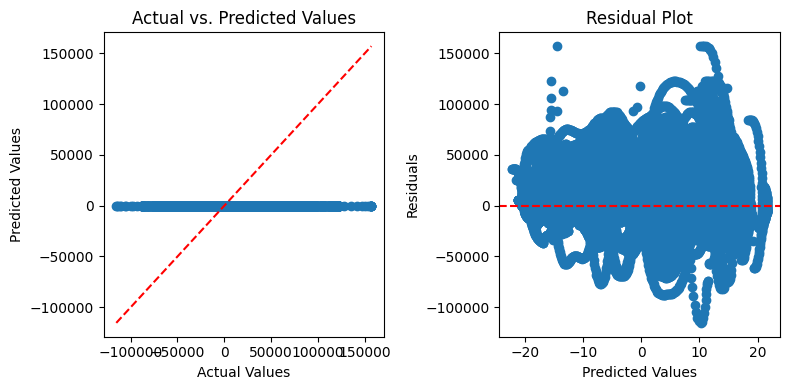

Mean Squared Error (MSE): 2.0219e+08
Mean Absolute Error (MAE): 7.9494e+03
R-squared (R²) Score: -1.9658e-02


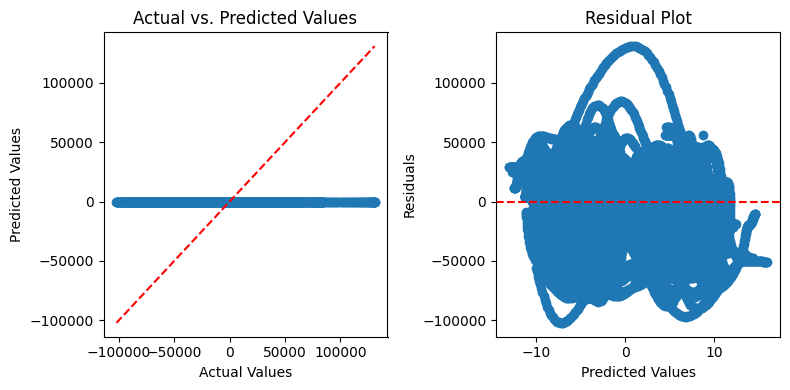

In [80]:

v_x_pred =  - c_1 * a_x[1:-1] + c_2 * a_x[0:-2]+ v_x[1:-1] - v_x[2:] 
v_y_pred =  - c_1 * a_y[1:-1] + c_2 * a_y[0:-2]+ v_y[1:-1] - v_x[2:] 

evaluate(v_x_pred, v_x[2:])
evaluate(v_y_pred, v_y[2:])

In [75]:
dt = 0.04

s_x_pred = s_x[1:-1] + dt * v_x[1:-1] + c_3 * a_x[1:-1] + c_4 * a_x[0:-2]
s_y_pred = s_y[1:-1] + dt * v_y[1:-1] + c_3 * a_y[1:-1] + c_4 * a_y[0:-2]


## Evaluation


In [76]:
def evaluate(y_test, y_pred):
    # Visualize the results

    plt.figure(figsize=(8, 4))
    # Evaluate the model using various metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the results in scientific notation
    print(f'Mean Squared Error (MSE): {mse:.4e}')
    print(f'Mean Absolute Error (MAE): {mae:.4e}')
    print(f'R-squared (R²) Score: {r2:.4e}')


    # Scatter plot of actual vs. predicted values with locus (line of identity)
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Locus
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0

    plt.tight_layout()
    plt.show()
 

Mean Squared Error (MSE): 1.6516e+09
Mean Absolute Error (MAE): 7.6181e+03
R-squared (R²) Score: -1.3102e-04


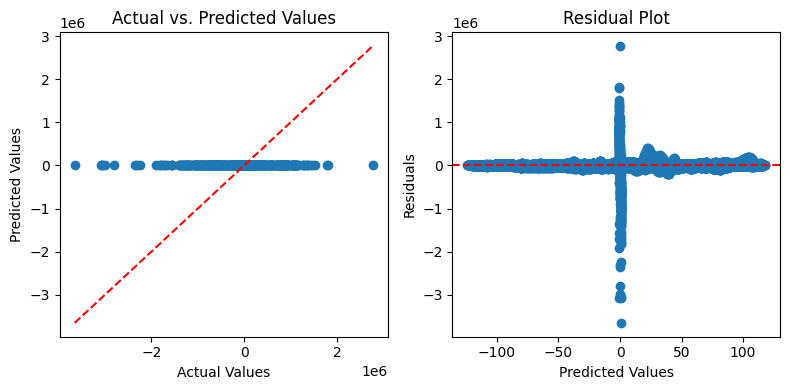

Mean Squared Error (MSE): 8.0852e+08
Mean Absolute Error (MAE): 7.0919e+03
R-squared (R²) Score: -6.5086e-05


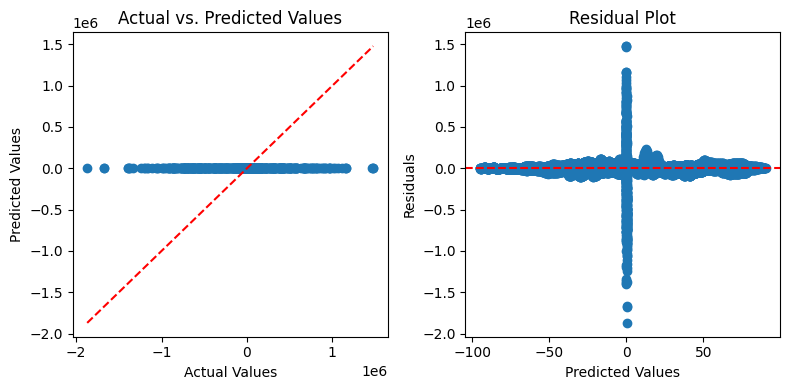

In [77]:
dt = 0.04
s_x_pred = s_x[1:-1] + dt * v_x[1:-1] + c_3 * a_x[1:-1] + c_4 * a_x[0:-2]
s_y_pred = s_y[1:-1] + dt * v_y[1:-1] + c_3 * a_y[1:-1] + c_4 * a_y[0:-2]

evaluate(s_x_pred, s_x[2:])
evaluate(s_y_pred, s_y[2:])


Mean Squared Error (MSE): 7.2504e+05
Mean Absolute Error (MAE): 1.5962e+02
R-squared (R²) Score: -7.5268e-04


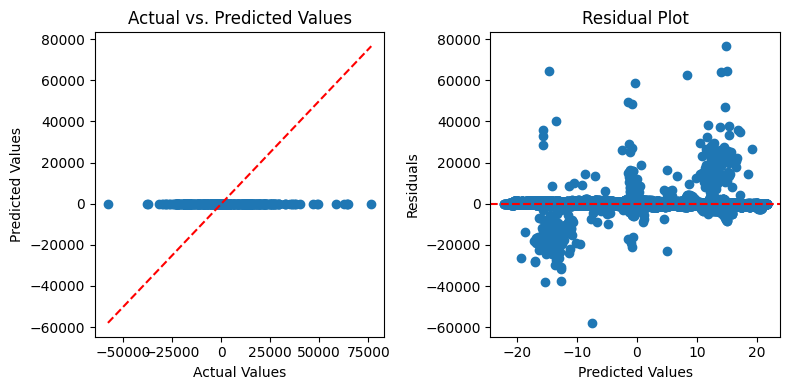

Mean Squared Error (MSE): 3.5493e+05
Mean Absolute Error (MAE): 1.4858e+02
R-squared (R²) Score: -7.1282e-04


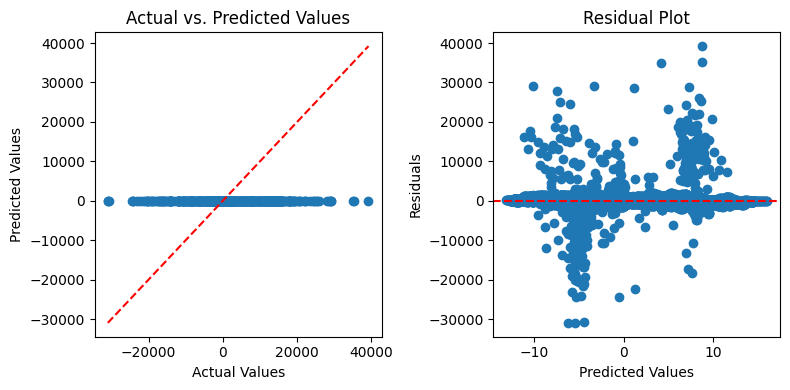

In [66]:

evaluate(v_x_pred, v_x[2:])
evaluate(v_y_pred, v_y[2:])

